In [ ]:
# Imports
from google.colab.patches import cv2_imshow
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
drive.mount('/content/drive')
%cd "drive/MyDrive/Stony Brook/Graduate Program/Project - CSE523"

Mounted at /content/drive
/content/drive/MyDrive/Stony Brook/Graduate Program/Project - CSE523


# Quad Deformation Matching

The Quadriceps muscle, an likely all muscles alike, can appear to be differently shaped depending of the angle, distance, and intrinsic properties of the muscle itself, especially in visual imaging. Before analysis of temperature sections can be completed, these differences must be resolved.

Example of issue shown in figure 1.

In figure 1, the left image shows the un-calibrated difference between the quadricep muscle group before and after exercise. The right is the calibrated version. In both, it is clear that issues exist with alignment of the skin regions. Note that calibration refers to the fact that the images were taken with different ranges of temperatures, meaning that each color did not refer to the same temperature.


Issues:
 - How to align leg horizontally and vertically?
  - Horizontally can likely be done by centering of skin-colored regions
  - Vertically, use kneecap?

Directory: Media/

Contracted & Flexed Quadriceps: FLIR_20220906_102026_232-Visual.jpeg

Extended Quadriceps: FLIR_20220906_103604_031-Visual.jpeg 

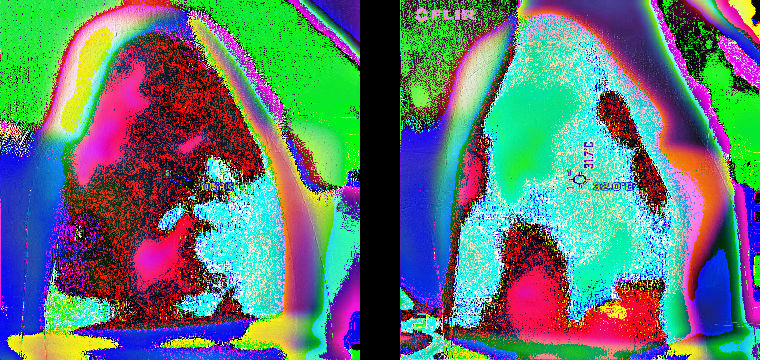

                Figure 1                                          Figure 2


In [ ]:
# Define Paths
computed_media_directory = "Computed Media/"
computed_img_1_fn = "color_difference_quadriceps_1.png"
computed_img_2_fn = "color_difference_quadriceps_2.png"

# Show Computed Images
computed_img_1 = cv2.imread(computed_media_directory + computed_img_1_fn)
computed_img_2 = cv2.imread(computed_media_directory + computed_img_2_fn)
figure_1_2 = np.concatenate((computed_img_1, np.zeros((computed_img_1.shape[0],40,3)), computed_img_2), axis=1)

cv2_imshow(figure_1_2)
print("                Figure 1                                          Figure 2")

## Next Steps

1. Load non-thermal (visual) images
2. Fit a line (likely using image gradient and color information) to the image such that it wraps the quadriceps.
3. Align manually (automatic will come later)
4. Perform non-affine "reformation" by moving the line on one image (the contracted image) and moving the line towards the other images line along the gradient (perpendicular) of the changing image. Note that a certain area will have to be compressed and stretched for this, but this can be taken care of by a library.
5. Perform the same transformation on the thermal images
6. Recompute calibrated and un-calibrated images
7. Re-asses project, draw observations and make conclusions.

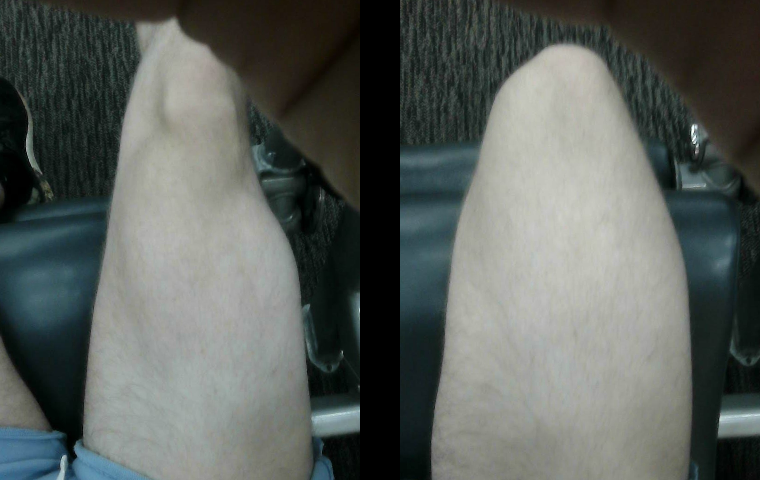

                Figure 1                                          Figure 2


In [ ]:
# Define Paths
media_directory = "Media/"
contracted_quad = "FLIR_20220906_102026_232.jpeg"
extended_quad = "FLIR_20220906_103604_031.jpeg"
contracted_visual_quad = "FLIR_20220906_102026_232-Visual.jpeg"
extended_visual_quad = "FLIR_20220906_103604_031-Visual.jpeg"

# Show Images
im1 = cv2.imread(media_directory + contracted_visual_quad)
im2 = cv2.imread(media_directory + extended_visual_quad)
im1_resize = cv2.resize(im1, (im1.shape[1]//3, im1.shape[0]//3))
im2_resize = cv2.resize(im2, (im2.shape[1]//3, im2.shape[0]//3))
im1_2 = np.concatenate((im1_resize, np.zeros((im1_resize.shape[0],40,3)), im2_resize), axis=1)

cv2_imshow(im1_2)
print("                Figure 1                                          Figure 2")

Fit a line to the image (skin boundary).

In [ ]:
def Get_Center(image):
  y_center = image.shape[0]//2
  x_center = image.shape[1]//2
  return x_center, y_center

"""
Returns a list of tuples:
(x,y,x_dif,y_dif)
where x,y are the points position, and x_dif, y_dif are the vector magnitudes 
from the original x,y to center of image.

Num_points decides how many points to fit to image
Radius decides the distance we move on each update step. In this function 
specifically, radius is the distance from any point to the image center.
"""
def Compute_Circular_Points(x_center, y_center, num_points, radius):
  circular_points = []
  # Circle equation: (x-h)^2 + (y-k)^2 = r^2 where (h,k) is center and r=radius

  for i in range(num_points//2 + 1):
      x = x_center - radius + 2*(i*2*radius)/(num_points)
      y = (radius**2 - (x-x_center)**2)**(1/2)
      circular_points.append((x, y_center + y, x-x_center, y))
      circular_points.append((x, y_center-y, x-x_center, -y))

  return circular_points

"""
Iteratively update points until we reach a threshold-based gradient.
"""
def Update_Points(image, circular_points, x_center, y_center, radius, threshold):

  # Move points outwards
  finished = True

  for i in range(len(circular_points)):
    point = circular_points[i]
    # Compute vector between center
    # print(point)

    new_point = (point[0] + point[2], point[1] + point[3])

    # print(image[int(new_point[0]), int(new_point[1])])
    # print(image[int(new_point[0]), int(new_point[1])] - image[int(point[0]), int(point[1])])
    # print(image[int(new_point[0])-2:int(new_point[0]+2), int(new_point[1])-2:int(new_point[1])+2] - image[int(point[0])-2:int(point[0])+2, int(point[1])-2:int(point[1])+2])
    # print(np.average(image[int(new_point[0])-2:int(new_point[0]+2), int(new_point[1])-2:int(new_point[1])+2]) - np.average(image[int(point[0])-2:int(point[0])+2, int(point[1])-2:int(point[1])+2]))
    print(abs(np.linalg.norm(image[int(new_point[0])-2:int(new_point[0]+2), int(new_point[1])-2:int(new_point[1])+2] - image[int(point[0])-2:int(point[0])+2, int(point[1])-2:int(point[1])+2])))
    if abs(np.linalg.norm(image[int(new_point[0])-2:int(new_point[0]+2), int(new_point[1])-2:int(new_point[1])+2] - image[int(point[0])-2:int(point[0])+2, int(point[1])-2:int(point[1])+2])) < threshold:
      circular_points[i] = (new_point[0], new_point[1], point[2], point[3])
      finished = False

  return circular_points, finished


# Parameters
num_points = 10
radius = 20
threshold = 2000

# Get center of image, initial configuration of points
x_center, y_center = Get_Center(im1)
circular_points = Compute_Circular_Points(x_center, y_center, num_points, radius)


while True:

  # Test circular points
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5)
  imgplot = plt.imshow(im1)
  xpts = [z[0] for z in circular_points]
  ypts = [z[1] for z in circular_points]
  plt.plot(xpts,ypts, '.')
  plt.plot(x_center, y_center, 'o')
  plt.show()

  circular_points, finished = Update_Points(im1, circular_points, x_center, y_center, radius, threshold)
  print(circular_points)
  if finished:
    break

Output hidden; open in https://colab.research.google.com to view.

From this, we can conclude that a naive gradient based edge detection method is not sufficient. It cannot accurately determine the edge boundaries. A more complex method such as using RINDNet must be used.